# MidTerm Project 

## Cancer Diagnoses with PyTorch Image Processing

#### Summary of the Project:
--> Development of deep learning model for classification of skin lesions, with the ultimate objective of diagnosis of various skin conditions.Dataset includes patient/demographic details like gender, age, and lesion location on the body and Image, Lesion_id's.

--> Initially, data preprocessing and exploration.
Where image files are filtered based on file extension, and lesion types are mappedto their corresponding categories for furthur analysis and model training

-->To improve the model's robustness and avoid overfitting, a pretrained version of the ResNetX101 model is used, and data augmentation techniques are implemented during training.The dataset is divided into validation and training sets in order to assess the performance of the model.Metrics like training loss and validation accuracy are tracked during the training phase to evaluate the model's development and effectiveness.

--> Finally, the model achieved best accuracy and decreasing loss over epochs.


Dataset: The HAM10000 dataset comprises approximately 10,000 labeled images depicting skin lesions. It includes patient/demographic details like gender, age, and lesion location on the body and Image, Lesion_id's.
The dataset is downloaded and used from kaggle : https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data 

Original Challenge: https://challenge2018.isic-archive.com
A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018; https://arxiv.org/abs/1902.03368
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T


References:
[1]Building a Skin Lesion Classification Web AppUsing Keras and TensorFlow.js to classify seven types of skin lesions
https://github.com/uyxela/Skin-Lesion-Classifier, by Alex Yu published in TowardsdataScience on December 16,2018 
[2] A new machine-learning based diagnostic tool for differentiation of dermatoscopic skin cancer images.https://github.com/tajerian/ham10000-app/blob/main/skin_cancer_Ham10000.ipynb , by tejarian

In [1]:
import os
from glob import glob
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Assuming the directory contains both CSV file and image files
directory = "C:\\Users\\ashri\\Documents\\AIT-736\\input\\HAM10000_images_part_1"

# List all files in the directory
all_files = os.listdir(directory)
#all_files

In [3]:
# Filter image files
# filter out only the file names that end with the extension '.jpg' 
image_files = [f for f in all_files if f.endswith('.jpg')]

# Ensure image_files is not empty
if not image_files:
    print("No image files found.")
else:
    print(f"Total image files: {len(image_files)}")

Total image files: 5000


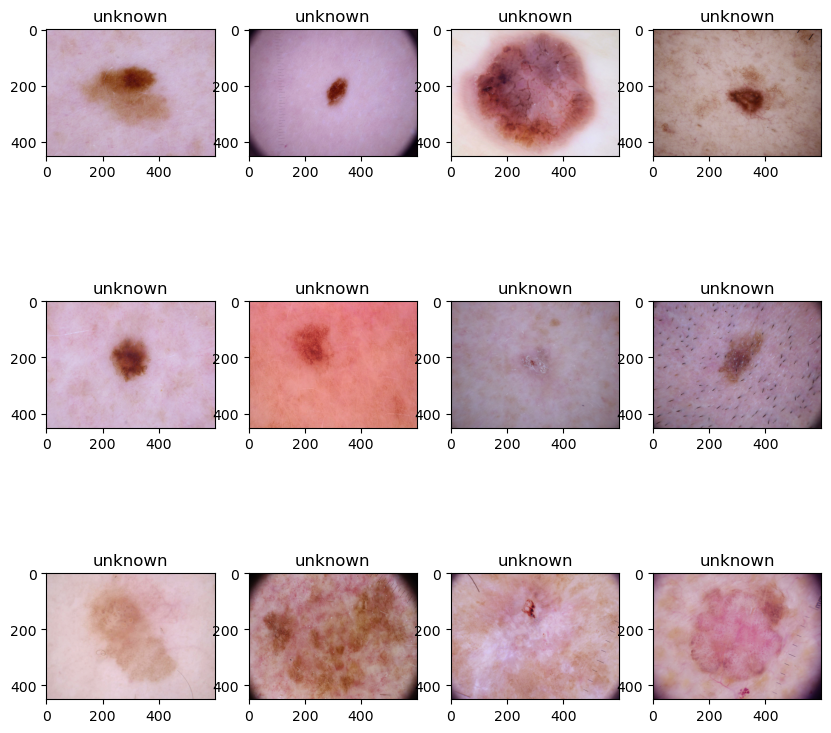

In [4]:
#from pathlib import Path
#path = Path(r"C:\\Users\\ashri\\Documents\\AIT-736\\input\\HAM10000_images_part_1")
#all_image_path = glob(os.path.join(path, '*', '*.jpg'))
#image_files = [f for f in path if f.endswith('.jpg')]
#imageid_path_dict = {row['image_id']: os.path.join(path, 'HAM10000_images_part_1', row['image_id'] + '.jpg') for _, row in metadata_df.iterrows()}
#imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_files}

#mappings of lesion types (abbreviations) to their corresponding full names
import random
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Assuming columns and rows are defined elsewhere
fig = plt.figure(figsize=(10, 10))
ax = []

# Assuming start and end are properly defined
start = 0
end = len(image_files) - 1

columns = 4
rows = 3

#randomly select an image file and get lesion type
for i in range(columns*rows):
    k = random.randint(start, end)
    if k < len(image_files):
        img_path = os.path.join(directory, image_files[k])
        img = mpimg.imread(img_path)
        ax.append(fig.add_subplot(rows, columns, i+1))
        ax[-1].set_title(lesion_type_dict.get(image_files[k].split('.')[0],'unknown')) 
# we can put 'unknown' because it doesnot explictly print the image name here but here the image type 
#is indirectly used to obtained the lesion type from 'lesion_type_dict'
        plt.imshow(img)
        
        # Check the size and number of channels in the image
        arr = np.asarray(Image.open(img_path))
        
    else:
        print(f"Index {k} out of range")

plt.show()

In [5]:
df_original = pd.read_csv(os.path.join(directory, 'HAM10000_metadata.csv'))

# Assuming imageid_path_dict and lesion_type_dict are properly defined
imageid_path_dict = {image_id: os.path.join(directory, image_id + '.jpg') for image_id in df_original['image_id'] if image_id + '.jpg' in image_files}
# Map image IDs to paths
df_original['path'] = df_original['image_id'].map(lambda x: imageid_path_dict.get(x, 'Unknown'))

# Map lesion types to cell types
df_original['cell_type'] = df_original['dx'].map(lambda x: lesion_type_dict.get(x, 'Unknown'))

# Convert cell types to categorical codes
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Unknown,Benign keratosis-like lesions,2


<Axes: xlabel='count', ylabel='cell_type'>

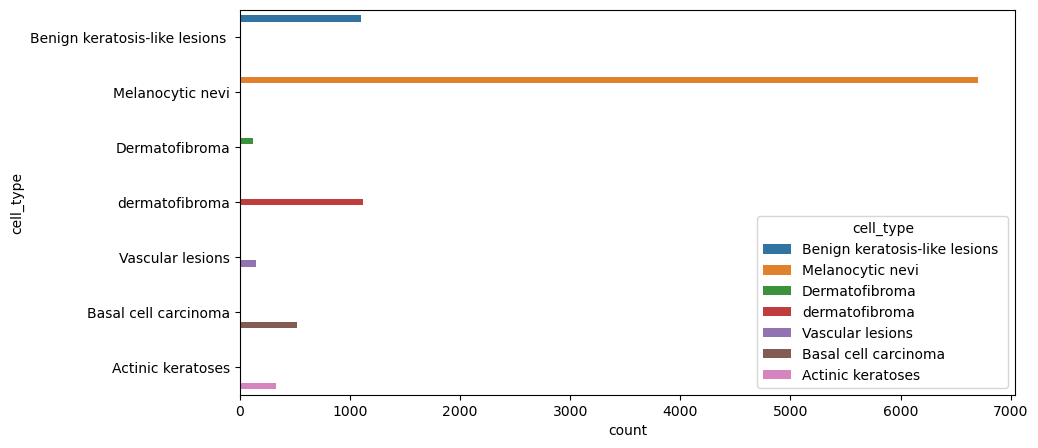

In [6]:
import seaborn as sns
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='cell_type',data=df_original, hue="cell_type",ax=ax1)

In [7]:
df_original['cell_type'].value_counts()

Melanocytic nevi                  6705
dermatofibroma                    1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In the table below, we have a nice overview of our groundtruth data. What we care for is only the column 'cell_type_idx', because these values are needed for the model training and get to know how often different tumors occur.

In [8]:
df_original[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
2370,5,Vascular lesions
1577,6,dermatofibroma


In [9]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [11]:
#normMean = [0.7630358, 0.54564357, 0.5700475]
#normStd = [0.14092763, 0.15261263, 0.16997081]
# for future reference

In [10]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# identify and filter out lesion IDs that have only one image associated with them in the original dataFrame.
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [11]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Unknown,Benign keratosis-like lesions,2,duplicated


In [12]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [13]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [14]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [15]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [16]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))


8912
1103


In [17]:
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
dermatofibroma                    1067
Benign keratosis-like lesions     1011
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: cell_type, dtype: int64

In [18]:
df_val['cell_type'].value_counts()


Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

From From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.

In [19]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

C:\Users\ashri\AppData\Local\Temp\ipykernel_27576\1237178497.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)


Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

In [20]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()

In [21]:
print(len(df_train))
df_train.sample(5)

35967


,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,train_or_val
26725,26725,HAM_0007097,ISIC_0033762,vasc,histo,60.0,male,trunk,Unknown,Vascular lesions,5,duplicated,train
13344,13344,HAM_0001503,ISIC_0025940,bcc,histo,55.0,male,face,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Basal cell carcinoma,1,unduplicated,train
12811,12811,HAM_0007601,ISIC_0032437,akiec,histo,65.0,male,upper extremity,Unknown,Actinic keratoses,0,duplicated,train
7973,7973,HAM_0002861,ISIC_0031462,nv,histo,55.0,male,upper extremity,Unknown,Melanocytic nevi,4,unduplicated,train
21069,21069,HAM_0000893,ISIC_0025345,bkl,histo,70.0,male,lower extremity,C:\Users\ashri\Documents\AIT-736\input\HAM1000...,Benign keratosis-like lesions,2,duplicated,train


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
class PretrainedResNext(nn.Module):
    def __init__(self, num_class=7):
        super().__init__()
        resNext = models.resnext101_32x8d(pretrained=True)
        self.channels = resNext.fc.out_features
        for params in resNext.parameters():
            params.requires_grad_(False)
        self.features = nn.Sequential(*list(resNext.children()))
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(self.channels, num_class)
        self.softmax = nn.Softmax()

    def forward(self, x):
        features = self.features(x)
        out = self.relu(features)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(-1, self.channels)
        out = self.fc1(out)
        out = self.SoftMax(out)
        return out

In [59]:
model = PretrainedResNext()
model_ft = models.resnext101_32x8d(pretrained=True)
model_ft.fc = nn.Linear(in_features=2048, out_features=7)
model_ft
model = model_ft

In [67]:
input_size = 224
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(normMean, normStd)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(normMean, normStd)])

In [68]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)
        return X, y

In [69]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = CustomDataset(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = CustomDataset(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [70]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [71]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.shape, 'label shape',labels.shape)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [72]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [73]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [74]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1124], [train loss 1.80869], [train acc 0.28031]
[epoch 1], [iter 200 / 1124], [train loss 1.65129], [train acc 0.35000]
[epoch 1], [iter 300 / 1124], [train loss 1.56649], [train acc 0.38750]
[epoch 1], [iter 400 / 1124], [train loss 1.50890], [train acc 0.41250]
[epoch 1], [iter 500 / 1124], [train loss 1.46146], [train acc 0.43419]
[epoch 1], [iter 600 / 1124], [train loss 1.41541], [train acc 0.45568]
[epoch 1], [iter 700 / 1124], [train loss 1.38229], [train acc 0.46884]
[epoch 1], [iter 800 / 1124], [train loss 1.35558], [train acc 0.47969]
[epoch 1], [iter 900 / 1124], [train loss 1.33627], [train acc 0.48847]
[epoch 1], [iter 1000 / 1124], [train loss 1.30977], [train acc 0.49944]
[epoch 1], [iter 1100 / 1124], [train loss 1.28299], [train acc 0.51080]


 10%|█         | 1/10 [16:58<2:32:42, 1018.10s/it]

------------------------------------------------------------
[epoch 1], [val loss 1.22017], [val acc 0.56042]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 1.22017], [val acc 0.56042]
*****************************************************
[epoch 2], [iter 100 / 1124], [train loss 1.00207], [train acc 0.63219]
[epoch 2], [iter 200 / 1124], [train loss 0.98475], [train acc 0.63562]
[epoch 2], [iter 300 / 1124], [train loss 0.96301], [train acc 0.64135]
[epoch 2], [iter 400 / 1124], [train loss 0.95484], [train acc 0.64422]
[epoch 2], [iter 500 / 1124], [train loss 0.93646], [train acc 0.64919]
[epoch 2], [iter 600 / 1124], [train loss 0.91998], [train acc 0.65589]
[epoch 2], [iter 700 / 1124], [train loss 0.90887], [train acc 0.66018]
[epoch 2], [iter 800 / 1124], [train loss 0.89506], [train acc 0.66461]
[epoch 2], [iter 900 / 1124], [train loss 0.88302], [train acc 0.66837]
[epoch 2], 

 20%|██        | 2/10 [33:56<2:15:46, 1018.31s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.58504], [val acc 0.80077]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.58504], [val acc 0.80077]
*****************************************************
[epoch 3], [iter 100 / 1124], [train loss 0.71210], [train acc 0.72375]
[epoch 3], [iter 200 / 1124], [train loss 0.71432], [train acc 0.72047]
[epoch 3], [iter 300 / 1124], [train loss 0.71204], [train acc 0.72448]
[epoch 3], [iter 400 / 1124], [train loss 0.71059], [train acc 0.72758]
[epoch 3], [iter 500 / 1124], [train loss 0.70136], [train acc 0.73194]
[epoch 3], [iter 600 / 1124], [train loss 0.69426], [train acc 0.73417]
[epoch 3], [iter 700 / 1124], [train loss 0.69041], [train acc 0.73612]
[epoch 3], [iter 800 / 1124], [train loss 0.68231], [train acc 0.73836]
[epoch 3], [iter 900 / 1124], [train loss 0.67616], [train acc 0.74090]
[epoch 3], 

 30%|███       | 3/10 [50:54<1:58:46, 1018.10s/it]

------------------------------------------------------------
[epoch 3], [val loss 0.58131], [val acc 0.78369]
------------------------------------------------------------
[epoch 4], [iter 100 / 1124], [train loss 0.59879], [train acc 0.77938]
[epoch 4], [iter 200 / 1124], [train loss 0.60249], [train acc 0.77516]
[epoch 4], [iter 300 / 1124], [train loss 0.60945], [train acc 0.76958]
[epoch 4], [iter 400 / 1124], [train loss 0.60117], [train acc 0.77187]
[epoch 4], [iter 500 / 1124], [train loss 0.60075], [train acc 0.77294]
[epoch 4], [iter 600 / 1124], [train loss 0.59665], [train acc 0.77406]
[epoch 4], [iter 700 / 1124], [train loss 0.59360], [train acc 0.77393]
[epoch 4], [iter 800 / 1124], [train loss 0.58778], [train acc 0.77570]
[epoch 4], [iter 900 / 1124], [train loss 0.58246], [train acc 0.77753]
[epoch 4], [iter 1000 / 1124], [train loss 0.58004], [train acc 0.77772]
[epoch 4], [iter 1100 / 1124], [train loss 0.57689], [train acc 0.77878]


 40%|████      | 4/10 [1:07:49<1:41:43, 1017.27s/it]

------------------------------------------------------------
[epoch 4], [val loss 0.40174], [val acc 0.85167]
------------------------------------------------------------
*****************************************************
best record: [epoch 4], [val loss 0.40174], [val acc 0.85167]
*****************************************************
[epoch 5], [iter 100 / 1124], [train loss 0.55246], [train acc 0.78938]
[epoch 5], [iter 200 / 1124], [train loss 0.52913], [train acc 0.80063]
[epoch 5], [iter 300 / 1124], [train loss 0.53216], [train acc 0.79917]
[epoch 5], [iter 400 / 1124], [train loss 0.52865], [train acc 0.79891]
[epoch 5], [iter 500 / 1124], [train loss 0.52398], [train acc 0.80169]
[epoch 5], [iter 600 / 1124], [train loss 0.51859], [train acc 0.80333]
[epoch 5], [iter 700 / 1124], [train loss 0.51927], [train acc 0.80263]
[epoch 5], [iter 800 / 1124], [train loss 0.51602], [train acc 0.80367]
[epoch 5], [iter 900 / 1124], [train loss 0.51113], [train acc 0.80590]
[epoch 5], 

 50%|█████     | 5/10 [1:24:41<1:24:37, 1015.52s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.57715], [val acc 0.80589]
------------------------------------------------------------
[epoch 6], [iter 100 / 1124], [train loss 0.45108], [train acc 0.82750]
[epoch 6], [iter 200 / 1124], [train loss 0.46029], [train acc 0.82828]
[epoch 6], [iter 300 / 1124], [train loss 0.45889], [train acc 0.82667]
[epoch 6], [iter 400 / 1124], [train loss 0.45821], [train acc 0.82633]
[epoch 6], [iter 500 / 1124], [train loss 0.46197], [train acc 0.82431]
[epoch 6], [iter 600 / 1124], [train loss 0.45755], [train acc 0.82568]
[epoch 6], [iter 700 / 1124], [train loss 0.45892], [train acc 0.82536]
[epoch 6], [iter 800 / 1124], [train loss 0.45834], [train acc 0.82539]
[epoch 6], [iter 900 / 1124], [train loss 0.45540], [train acc 0.82649]
[epoch 6], [iter 1000 / 1124], [train loss 0.45271], [train acc 0.82750]
[epoch 6], [iter 1100 / 1124], [train loss 0.45412], [train acc 0.82730]


 60%|██████    | 6/10 [1:41:33<1:07:37, 1014.44s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.39255], [val acc 0.86226]
------------------------------------------------------------
*****************************************************
best record: [epoch 6], [val loss 0.39255], [val acc 0.86226]
*****************************************************
[epoch 7], [iter 100 / 1124], [train loss 0.41286], [train acc 0.83750]
[epoch 7], [iter 200 / 1124], [train loss 0.41218], [train acc 0.83891]
[epoch 7], [iter 300 / 1124], [train loss 0.41540], [train acc 0.84010]
[epoch 7], [iter 400 / 1124], [train loss 0.41665], [train acc 0.83969]
[epoch 7], [iter 500 / 1124], [train loss 0.41590], [train acc 0.84081]
[epoch 7], [iter 600 / 1124], [train loss 0.41282], [train acc 0.84250]
[epoch 7], [iter 700 / 1124], [train loss 0.41360], [train acc 0.84219]
[epoch 7], [iter 800 / 1124], [train loss 0.41131], [train acc 0.84359]
[epoch 7], [iter 900 / 1124], [train loss 0.40793], [train acc 0.84434]
[epoch 7], 

 70%|███████   | 7/10 [1:58:24<50:40, 1013.49s/it]  

------------------------------------------------------------
[epoch 7], [val loss 0.58368], [val acc 0.81482]
------------------------------------------------------------
[epoch 8], [iter 100 / 1124], [train loss 0.37170], [train acc 0.85594]
[epoch 8], [iter 200 / 1124], [train loss 0.36475], [train acc 0.85813]
[epoch 8], [iter 300 / 1124], [train loss 0.36713], [train acc 0.85646]
[epoch 8], [iter 400 / 1124], [train loss 0.36361], [train acc 0.85867]
[epoch 8], [iter 500 / 1124], [train loss 0.36654], [train acc 0.85700]
[epoch 8], [iter 600 / 1124], [train loss 0.37377], [train acc 0.85464]
[epoch 8], [iter 700 / 1124], [train loss 0.37110], [train acc 0.85616]
[epoch 8], [iter 800 / 1124], [train loss 0.37141], [train acc 0.85629]
[epoch 8], [iter 900 / 1124], [train loss 0.36979], [train acc 0.85750]
[epoch 8], [iter 1000 / 1124], [train loss 0.37156], [train acc 0.85694]
[epoch 8], [iter 1100 / 1124], [train loss 0.36989], [train acc 0.85787]


 80%|████████  | 8/10 [2:15:15<33:45, 1012.72s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.37449], [val acc 0.86137]
------------------------------------------------------------
[epoch 9], [iter 100 / 1124], [train loss 0.37609], [train acc 0.86125]
[epoch 9], [iter 200 / 1124], [train loss 0.37375], [train acc 0.86078]
[epoch 9], [iter 300 / 1124], [train loss 0.36262], [train acc 0.86250]
[epoch 9], [iter 400 / 1124], [train loss 0.35787], [train acc 0.86492]
[epoch 9], [iter 500 / 1124], [train loss 0.35107], [train acc 0.86825]
[epoch 9], [iter 600 / 1124], [train loss 0.34428], [train acc 0.87036]
[epoch 9], [iter 700 / 1124], [train loss 0.34389], [train acc 0.87009]
[epoch 9], [iter 800 / 1124], [train loss 0.34360], [train acc 0.87020]
[epoch 9], [iter 900 / 1124], [train loss 0.34287], [train acc 0.86993]
[epoch 9], [iter 1000 / 1124], [train loss 0.34182], [train acc 0.87016]
[epoch 9], [iter 1100 / 1124], [train loss 0.33975], [train acc 0.87043]


 90%|█████████ | 9/10 [2:32:07<16:52, 1012.46s/it]

------------------------------------------------------------
[epoch 9], [val loss 0.37572], [val acc 0.86226]
------------------------------------------------------------
[epoch 10], [iter 100 / 1124], [train loss 0.34467], [train acc 0.86687]
[epoch 10], [iter 200 / 1124], [train loss 0.33372], [train acc 0.87406]
[epoch 10], [iter 300 / 1124], [train loss 0.32989], [train acc 0.87417]
[epoch 10], [iter 400 / 1124], [train loss 0.32319], [train acc 0.87703]
[epoch 10], [iter 500 / 1124], [train loss 0.32259], [train acc 0.87731]
[epoch 10], [iter 600 / 1124], [train loss 0.31859], [train acc 0.87833]
[epoch 10], [iter 700 / 1124], [train loss 0.31411], [train acc 0.88004]
[epoch 10], [iter 800 / 1124], [train loss 0.30803], [train acc 0.88207]
[epoch 10], [iter 900 / 1124], [train loss 0.30850], [train acc 0.88149]
[epoch 10], [iter 1000 / 1124], [train loss 0.30917], [train acc 0.88097]
[epoch 10], [iter 1100 / 1124], [train loss 0.30855], [train acc 0.88134]


100%|██████████| 10/10 [2:48:58<00:00, 1012.03s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.35058], [val acc 0.87565]
------------------------------------------------------------
*****************************************************
best record: [epoch 10], [val loss 0.35058], [val acc 0.87565]
*****************************************************


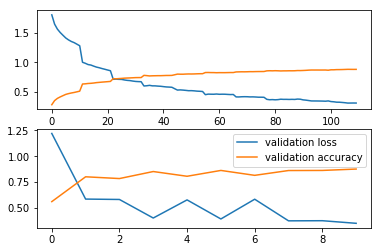

In [75]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [82]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
# plot_confusion_matrix(confusion_mtx, plot_labels)


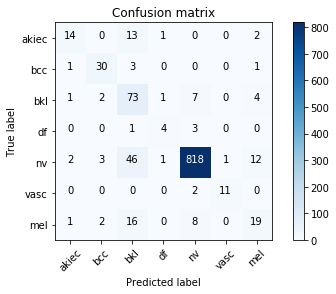

In [85]:
import itertools
plot_confusion_matrix(confusion_mtx, plot_labels)


In [83]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.74      0.47      0.57        30
         bcc       0.81      0.86      0.83        35
         bkl       0.48      0.83      0.61        88
          df       0.57      0.50      0.53         8
          nv       0.98      0.93      0.95       883
        vasc       0.92      0.85      0.88        13
         mel       0.50      0.41      0.45        46

    accuracy                           0.88      1103
   macro avg       0.71      0.69      0.69      1103
weighted avg       0.90      0.88      0.88      1103



Text(0, 0.5, 'Fraction classified incorrectly')

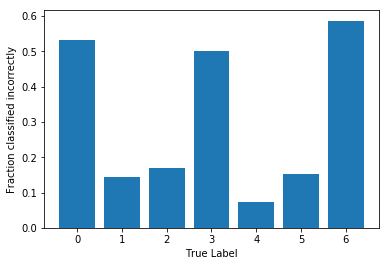

In [86]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')